# MIE1624 - Course Project - Group 4 - ParkFast

This projects consists of detecting parking spots in images for both off-street and on-street parking. Then for a designated spot, we want to predict when it will become available.

This notebook consists of three different section:
    - Off-street parking image classification
    - On-street parking image classification
    - Time Empty Prediction Model

Before going into the details of each section, let's set up a general environment by installing and importing useful librairies.

## Overall Environment Setup

**Install librairies**

In [1]:
!pip install numpy
!pip install matplotlib
!pip install Pillow
!pip install pandas
!pip install -U scikit-learn
!pip install sodapy
!pip install atari-py
!pip install --upgrade tensorflow

distributed 1.21.8 requires msgpack, which is not installed.
ibm-cos-sdk-core 2.3.0 has requirement requests<=2.18.4,>=2.12.0, but you'll have requests 2.20.1 which is incompatible.
distributed 1.21.8 requires msgpack, which is not installed.
ibm-cos-sdk-core 2.3.0 has requirement requests<=2.18.4,>=2.12.0, but you'll have requests 2.20.1 which is incompatible.
distributed 1.21.8 requires msgpack, which is not installed.
ibm-cos-sdk-core 2.3.0 has requirement requests<=2.18.4,>=2.12.0, but you'll have requests 2.20.1 which is incompatible.
distributed 1.21.8 requires msgpack, which is not installed.
ibm-cos-sdk-core 2.3.0 has requirement requests<=2.18.4,>=2.12.0, but you'll have requests 2.20.1 which is incompatible.
Requirement already up-to-date: scikit-learn in /home/jupyterlab/conda/lib/python3.6/site-packages (0.20.0)
Requirement not upgraded as not directly required: numpy>=1.8.2 in /home/jupyterlab/conda/lib/python3.6/site-packages (from scikit-learn) (1.14.3)
Requirement not u

**Import librairies**

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from PIL import Image

In [3]:
# This is needed to display the images
%matplotlib inline

**External File Downloads**

Download all the folders located here and store these folders in the same directory as the notebook: https://utoronto-my.sharepoint.com/:f:/g/personal/yasmina_khalife_mail_utoronto_ca/EofCCoKBI_dKjbEsImfEO_4BX9ey-_Gax-JPsPL7Hisp5Q?e=8IrLwX 

## Off-Street Parking

In [5]:
import six.moves.urllib as urllib
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO

# imports from the object detection module.
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

#Minimum requirement for tensorflow is 1.9.0
if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

Define key directory paths and filenames.

In [6]:
# download our trained model parking_detection_v2.
MODEL_FILE = 'parking_detection_v2.tar.gz'
DOWNLOAD_BASE = 'https://raw.githubusercontent.com/adi3104/ParkFast/master/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'parking_detection_v2/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'object-detection.pbtxt')

NUM_CLASSES = 1

Loading our locally-saved Tensorflow model of parking_detection_v2 into the notebook. This was done to save computing time when going through the entire notebook.

In [7]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [8]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

#### Loading label map
Label maps map indices to category names, so that when our convolution network predicts `1`, we know that this corresponds to `car`.  

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Convert image into a numpy array for plotting.

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

### Detection

Download Test images from network

In [11]:
# It will test 6 images in the folder "test_images"
# What model to download.
TEST_FILE = 'Test.tar.gz'

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + TEST_FILE, TEST_FILE)
tar_file = tarfile.open(TEST_FILE)
for file in tar_file.getmembers():
   tar_file.extract(file, os.getcwd())


PATH_TO_TEST_IMAGES_DIR = 'Test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (14, 8)

Use our trained model parking_detection_v2/frozen_inference_graph.pb as dataflow graph in tensorflow session to compute  the image's  detection results: 'num_detections', 'detection_boxes', 'detection_scores',  'detection_classes', 'detection_masks'

In [12]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

Run the tensorflow session for each image in the downloaded Test folder, compute the test results like: detection_boxes, detection_classes, detection_scores.

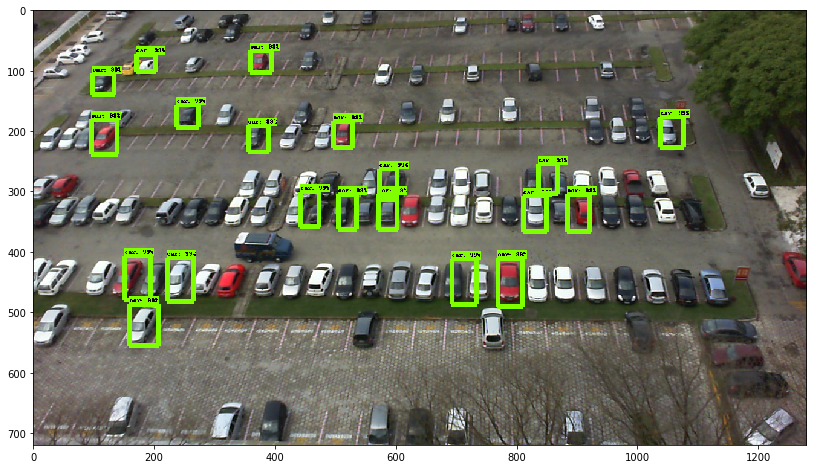

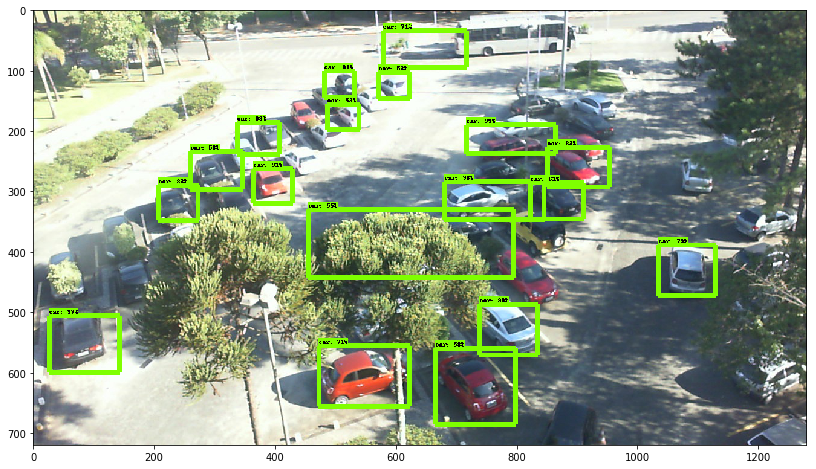

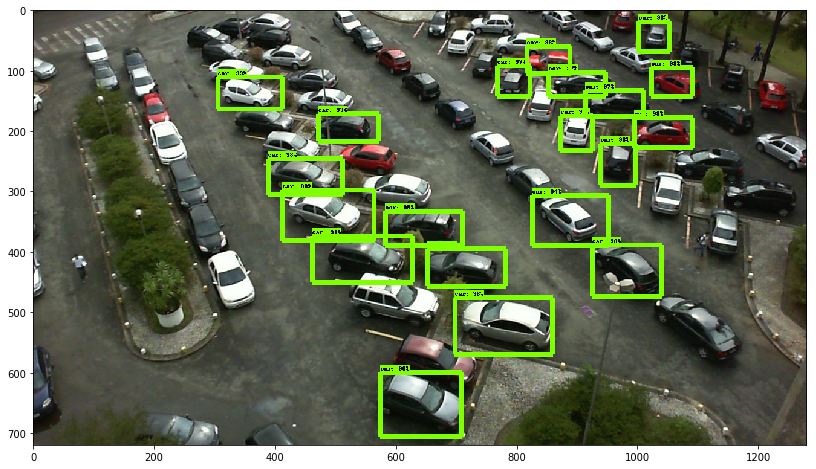

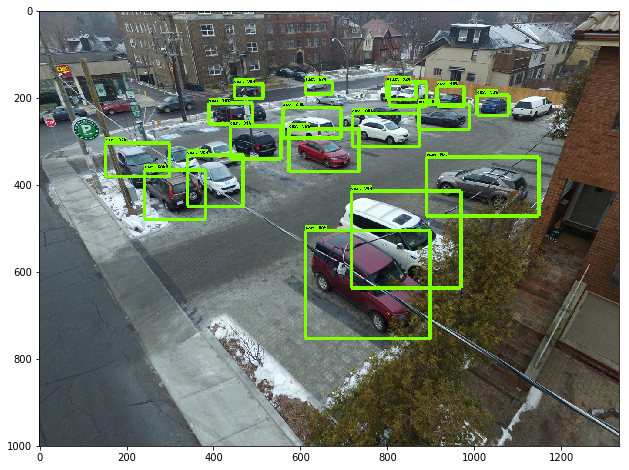

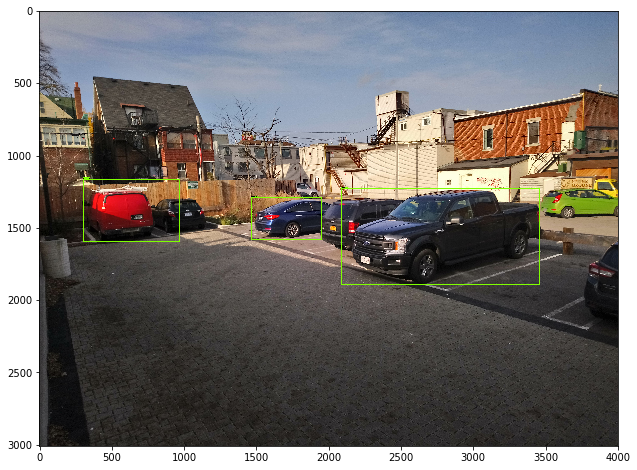

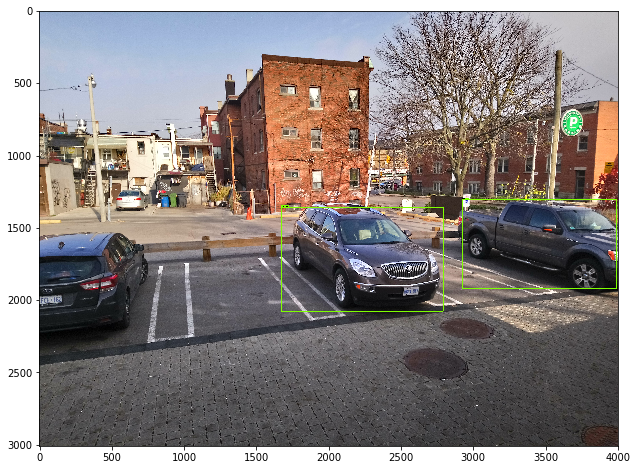

In [13]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

## On-Street Parking - detecting cars and potential parking spots in images

To detect specific objects in an image, we can use the Google Cloud Vision API. Cloud Vision contains pre-trained models that are very powerful and able to detect cars in an image from several different angles.

### Data Retrieval - Setting up and calling the API
### **Note**: This has already been done and is commented out. Results of API calls are saved locally

This sections outlines the steps required to call the API and store the response in a JSON file. All code cells are commented out as this is data retrieval process. The following section 'Detect object in images' reads the image files.

**Installation Requirements**

Several steps are required before starting to use this API. For detailed documentation, follow these instructions: https://cloud.google.com/vision/docs/quickstart-client-libraries

Otherwise here are the steps needed:


1.   Create a Google Cloud Project (create a Google Cloud account):
       https://console.cloud.google.com/cloud-resource-manager?_ga=2.131570056.-68706030.1540057552
      
2.   Enable billing for the project:
      https://cloud.google.com/billing/docs/how-to/modify-project
      
      **Notes**: 

      *   With a new Google Cloud account, there should be $300 Google Cloud credits valid for a year
      
      * With an older Google Cloud account, it could be required to enter credit card information, however, there won't be any charges for this project as the first 1 000 API calls per month are free. Additional API requests are charged at $1.50 USD per month up to 5 000 000 calls.
     
     
3.    Enable the API:
      https://console.cloud.google.com/flows/enableapi?apiid=vision-json.googleapis.com&_ga=2.228039322.-68706030.1540057552
      
      
4.   Set up authentication

      *   In the Google Cloud Project Console, go to the create service account key page:
      https://console.cloud.google.com/apis/credentials/serviceaccountkey?_ga=2.164540728.-68706030.1540057552
      *   From the Service account drop-down list, select New service account.    

      *   In the Service account name field, enter a name .
      *   From the Role drop-down list, select Project > Owner.
      *   Click Create. A JSON file that contains your key downloads to your computer.


5.  Set the environment variable GOOGLE_APPLICATION_CREDENTIALS to the file path of the JSON file that contains your service account key. This variable only applies to your current shell session, so if you open a new session, set the variable again.

      *   In Linux or Mac, run the command:
      !export GOOGLE_APPLICATION_CREDENTIALS="[PATH]"
      *   In Windows, run the command:
      !export GOOGLE_APPLICATION_CREDENTIALS="/home/user/Downloads/service-account-file.json"

6. Install the client library:
     
     !pip install --upgrade google-cloud-vision

**Install Google Cloud library**

In [14]:
#!pip install --upgrade google-cloud-vision

**Locate the API credential file**

Note that the file StreetParking-659d4fd5f25c.json is not provided in the project as it contains the credentials to use the API. To run the cell below, replace with the file name with the appropriate credential file generated from the instructions outlined above.

In [15]:
# import os
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="StreetParking-659d4fd5f25c.json"

**Import libraries**

In [16]:
# import json

# #Imports the Google Cloud client library
# from google.cloud import vision
# from google.cloud.vision import types
# from google.protobuf.json_format import MessageToDict

**Instantiate a client**

In [17]:
# client = vision.ImageAnnotatorClient()

**Call the API for each image**

Let's create a function to call the API for each of the images stored in a specific directory and store the JSON response files into a new folder.

In [18]:
# def get_response(image_dir, response_dir):
#     '''
#     Input:
#     image_dir: directory containing the images
#     response_dir: directory containing the respones
    
#     Output: the JSON responses of the images
#     '''
    
#     if not os.path.exists(response_dir):
#         os.makedirs(response_dir)

#     # for each image in the image directory, call the API and store the response
#     for filename in os.listdir(image_dir):

#         # Loads the image into memory
#         with open(image_dir + filename, 'rb') as image_file:
#             content = image_file.read()
#         image = vision.types.Image(content=content)

#         # get the response
#         objects = client.object_localization(image=image)

#         # store the response in a JSON file
#         with open(response_dir + '/' + filename.strip('.png') + '.json', 'w') as fp:
#             serialized = MessageToDict(objects,preserving_proto_field_name=True)
#             json.dump(serialized, fp)
    
#     return None

In [19]:
# # directory of images
# im_dir = 'onstreet_parking_images/'

# # directory to store the json responses
# json_dir = 'onstreet_parking_json_responses'

# get_response(im_dir,json_dir)

# # for extra images
# im_dir_extra = 'onstreet_parking_images_extra/'
# json_dir_extra = 'onstreet_parking_json_responses_extra'

# get_response(im_dir_extra, json_dir_extra)

### Detect the objects in the image

**Load the json files and identifies the cars**

For each JSON response from the Google Cloud Vision API, let's find out if the object Car was identified and where it is located in the image. Let's take a look at a sample JSON response.

In [20]:
import json
with open('onstreet_parking_json_responses/onstreet_parking_a.json') as f:
        print(json.load(f))

{'localized_object_annotations': [{'mid': '/m/03jm5', 'name': 'House', 'score': 0.5280822515487671, 'bounding_poly': {'normalized_vertices': [{'x': 0.5457547903060913, 'y': 0.00500292144715786}, {'x': 0.7843630313873291, 'y': 0.00500292144715786}, {'x': 0.7843630313873291, 'y': 0.5467617511749268}, {'x': 0.5457547903060913, 'y': 0.5467617511749268}]}}, {'mid': '/m/03jm5', 'name': 'House', 'score': 0.5181453824043274, 'bounding_poly': {'normalized_vertices': [{'x': 0.01500001922249794, 'y': 0.015000018291175365}, {'x': 0.5577058792114258, 'y': 0.015000018291175365}, {'x': 0.5577058792114258, 'y': 0.5849999785423279}, {'x': 0.01500001922249794, 'y': 0.5849999785423279}]}}]}


We see that the vertices of the objects are located in `['bounding_poly']['normalized_vertices']`. Let's create a function which will extract these vertices and return the location of the objects in the images. Since the vertices given in the JSON file are normalized, we multiply them by the image dimensions to obtain the unnormalized vertices. 

In [21]:
def get_vertices(obj, im_height, im_width):
    '''
    Input: 
    obj_info: a JSON object 
    im_height: the image height
    im_width: the image width
    
    Output: the vertices of the object on the image
    '''

    
    # when the object is located on the side of the image, the x coordinate is absent from the list of vertices
    # in this case set the x vertice to 0
    x_norm = obj['bounding_poly']['normalized_vertices'][0].get('x')
    
    if x_norm is None:
        x_norm = 0
    
    width_norm = obj['bounding_poly']['normalized_vertices'][1]['x']
    
    if width_norm is None:
        width_norm = 0
    
    
    # the normalized vertices are given so multiply by the width and height of the image to obtain the vertices
    x = x_norm*im_width
    y = obj['bounding_poly']['normalized_vertices'][0]['y']*im_height
    height = obj['bounding_poly']['normalized_vertices'][2]['y']*im_height - y
    width = width_norm*im_width - x
    
    
    return x,y,height,width

Now that we have the vertices, we want to display rectangles around the objects found. The function plot_rect displays a rectangle with x,y coordinates given.

In [22]:
import matplotlib.patches as patches

def plot_rect(ax,x,y,width,height,obj_name,obj_num,color):
    '''
    Input: 
    ax: the axe of the image
    x: the bottom left x coordinate of the rectangle
    y: the bottom left y coordinate of the rectangle
    width: the width of the rectangle
    height: the height of the rectangle
    obj_name: the name of the object to display above the rectangle
    obj_num: the number of the object to display above the rectangle
    color: the color of the rectangle
    
    Ouput: displays a rectangle on an image with the object annotated and prints the vertices of the rectangle
    '''
    
    rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor=color,facecolor='none')
    print(rect)

    # Add the patch to the Axes
    ax.add_patch(rect)

    ax.annotate(obj_name + ' {}'.format(obj_num), (x, y), color=color, weight='bold', xycoords='data', fontsize=14, 
                ha='left', va='bottom')
    
    return None

Let's display each image with the cars detected and their vertices.

The following `car_detection` function does the following:
1. Loops over every JSON response
2. Find the corresponding image
3. Display the image with the bounding box around the objects detected (cars and parking spots)

In [23]:
def car_detection(image_dir, response_dir, conditions = None, save_image = False):
    '''
    Input:
    image_dir: the directory containing the images
    response+dir: the directory containing the JSON responses
    conditions: directionary containing conditions to be applied to the image
    save_image: indicate if the results should be saved to a file
    
    Ouput:
    Plots of the images with vehicles identified
    '''

    # for each json file identify if a car was present
    for filename in os.listdir(response_dir):

        # for Mac, ignore this file if present in the directory
        if filename == 'DS_Store.json':
            continue
          
        # print image name
        print('Image: {}'.format(filename.rstrip(".json")))

        # open the file
        with open(response_dir + filename) as f:
            objects = json.load(f)
            

        obj_info = objects['localized_object_annotations']

        
        # open the corresponding image
        im_file = image_dir + filename.rstrip('.json') + '.png'
        im = Image.open(im_file)

        # convert the image to numpy array for plotting
        im_arr = np.array(im)

        # Create figure and axes for plotting
        fig,ax = plt.subplots(1,figsize=(10,10))
        ax.imshow(im_arr)

        # get image size
        im_width,im_height = (im).size

        # count for the number of vehicles
        num_cars = 0
        
        # store the vertices in a dataframe
        obj_locations = pd.DataFrame(columns = ['obj_x','obj_width'])
        
        
        for object_ in obj_info:

            # ignore objects detected which are not cars
            if object_['name'] != 'Car':
                continue
                
            # get the confidence that the object is a car
            confidence = object_['score']
            
            if conditions is not None:
                if confidence < conditions['confidence']:
                    continue

            num_cars += 1
            
            # display the confidence that the object is car
            print('car %d' % (num_cars))
            print('confidence %.2f' %(confidence))
            
            # get the vertices of the object and plot the rectangle around the car
            obj_x, obj_y, obj_height, obj_width = get_vertices(object_, im_height, im_width)
            plot_rect(ax,obj_x,obj_y,obj_width,obj_height,'car',num_cars,'r')
            
            # store the vertices in the dataframe
            obj_locations = obj_locations.append({'obj_x':obj_x,'obj_width':obj_width}, ignore_index = True)

            
        # display the number of cars found 
        ax.set_title('Number of vehicles found: {}'.format(num_cars))
            
        # apply conditions
        if conditions is not None:

            obj_locations.sort_values(['obj_x'], inplace = True)
            
            # compute the distance in x between each car
            obj_locations['dist_cars'] = obj_locations['obj_x'].shift(-1) - obj_locations['obj_x'] \
                                        - obj_locations['obj_width']

            # store the x location of potential parking spots
            rect_x_loc = []
            
            # if no cars where detected, the first x location of a potential spot starts at 0
            if obj_locations.empty:
                
                rect_x_loc = [x for x in range(0, im_width-conditions['width']) if x % conditions['width'] == 0]
                
            # if only one car is detected, the x location begins after this car
            elif obj_locations.dist_cars.isnull().all(): 
                
                rect_x_loc = [x for x in range(int(obj_locations['obj_x'] + obj_locations['obj_width']), 
                                               im_width-conditions['width']) if x % conditions['width'] == 0 \
                                                or x == int(obj_locations['obj_x'] + obj_locations['obj_width'])]

            # if several cars were detected, the x location of a spot is in any between those cars
            elif (obj_locations.dist_cars[obj_locations.dist_cars > conditions['width']].any()):

                rect_x_loc = list(obj_locations['obj_x'][obj_locations.dist_cars > conditions['width']] \
                                  + obj_locations['obj_width'][obj_locations.dist_cars> conditions['width']])

            # plot the available parking spots
            for x in rect_x_loc:
                plot_rect(ax,x,conditions['y'],conditions['width'],conditions['height'],'potential spot',
                          rect_x_loc.index(x)+1,'y')
        

        # hide the axes
        ax.set_xticks([])
        ax.set_yticks([])

        plt.autoscale(False)

        # display the image 
        plt.show()
        
        if save_image:
            
            # create a new directory with the results
            results_dir = 'onstreet_parking_results'
            if not os.path.exists(results_dir):
                 os.makedirs(results_dir)
            
            # save the result
            fig.savefig(results_dir + '/' + filename.rstrip('.json') + '.png', dpi=90, bbox_inches='tight')
        
    return None 

Image: onstreet_parking_c
car 1
confidence 0.95
Rectangle(xy=(1.75483, 648.754), width=838.221, height=335.308, angle=0)
car 2
confidence 0.62
Rectangle(xy=(3.18899, 538.112), width=222.734, height=169.88, angle=0)


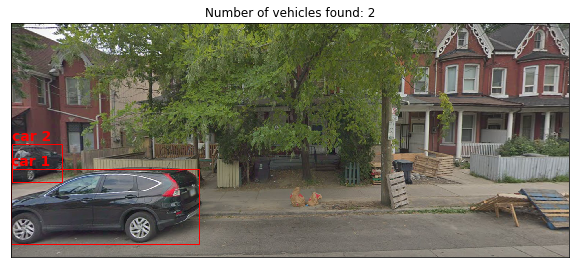

Image: onstreet_parking_a


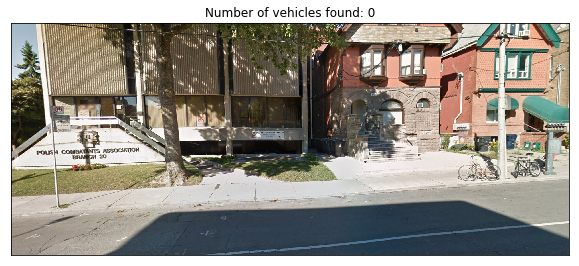

Image: onstreet_parking_d
car 1
confidence 0.90
Rectangle(xy=(6.45507, 710.272), width=709.47, height=302.312, angle=0)
car 2
confidence 0.84
Rectangle(xy=(1596.16, 667.864), width=845.613, height=325.128, angle=0)
car 3
confidence 0.71
Rectangle(xy=(677.194, 676.048), width=819.793, height=337.032, angle=0)


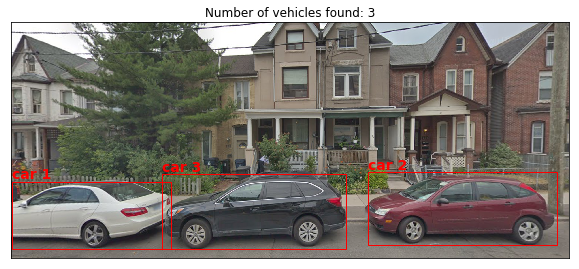

Image: onstreet_parking_b
car 1
confidence 0.87
Rectangle(xy=(1150.92, 619.376), width=655.23, height=265.094, angle=0)
car 2
confidence 0.73
Rectangle(xy=(1901.52, 618.882), width=598.714, height=263.118, angle=0)
car 3
confidence 0.71
Rectangle(xy=(4.20102, 645.801), width=281.861, height=217.303, angle=0)


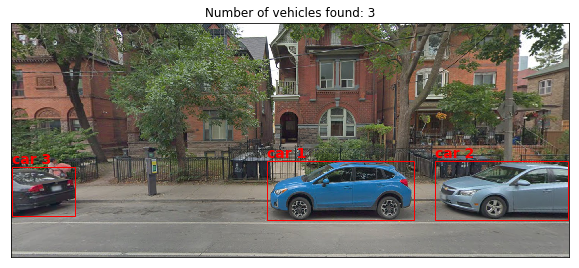

In [24]:
# json files directory and image directory
resp_dir = 'onstreet_parking_json_responses/'
im_dir = 'onstreet_parking_images/'

# plot the results for the 4 images stored in the directory onstreet_parking_images
car_detection(im_dir, resp_dir)

From the  image `onstreet_parking_c` above, we can see that a car was detected in a driveway behind a parked car. This is not very interesting for on-street parking so let's add a condition that the confidence should be greater than 65%. 

Also in this same image, even though there is a car parked on the street, we can clearly distinguish an available spot. Let's use the vertices of the rectangle of the cars parked and store them. These vertices define a rectangle for a potential parking spot. 

Let's apply the conditions above to the images and store the results. A standard car height and width is obtained by averaging all the car bounding boxes in an image.

In [25]:
# minimum confidence is 65%
min_conf = 0.65

# average width of cars whose width is fully visible
avg_width = int(np.mean([655.23,838.221,845.613,819.793]))

# average height of cars whose height is fully visible
avg_height = np.mean([265.094,263.118,217.303,335.308,302.312,325.128,337.032])

# average y coordinate of cars
avg_y = np.mean([619.376,618.882,645.801,648.754,710.272,667.864,676.048])

# store the conditions in a dictionary
conditions = {'confidence': min_conf, 'width': avg_width, 'height': avg_height, 'y': avg_y}     

**Applying conditions to images**

Image: onstreet_parking_c
car 1
confidence 0.95
Rectangle(xy=(1.75483, 648.754), width=838.221, height=335.308, angle=0)
Rectangle(xy=(839, 655.285), width=789, height=292.185, angle=0)
Rectangle(xy=(1578, 655.285), width=789, height=292.185, angle=0)


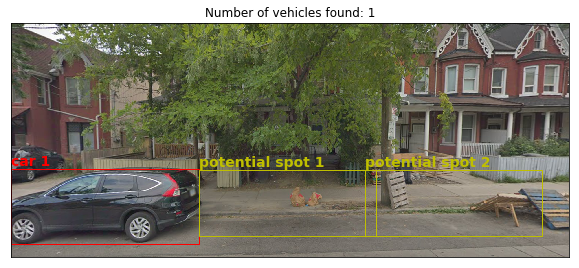

Image: onstreet_parking_a
Rectangle(xy=(0, 655.285), width=789, height=292.185, angle=0)
Rectangle(xy=(789, 655.285), width=789, height=292.185, angle=0)
Rectangle(xy=(1578, 655.285), width=789, height=292.185, angle=0)


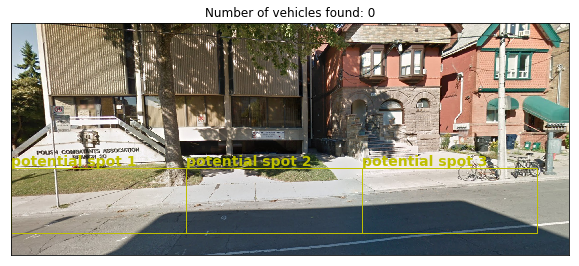

Image: onstreet_parking_d
car 1
confidence 0.90
Rectangle(xy=(6.45507, 710.272), width=709.47, height=302.312, angle=0)
car 2
confidence 0.84
Rectangle(xy=(1596.16, 667.864), width=845.613, height=325.128, angle=0)
car 3
confidence 0.71
Rectangle(xy=(677.194, 676.048), width=819.793, height=337.032, angle=0)


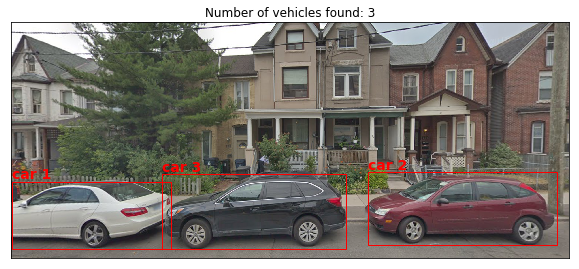

Image: onstreet_parking_b
car 1
confidence 0.87
Rectangle(xy=(1150.92, 619.376), width=655.23, height=265.094, angle=0)
car 2
confidence 0.73
Rectangle(xy=(1901.52, 618.882), width=598.714, height=263.118, angle=0)
car 3
confidence 0.71
Rectangle(xy=(4.20102, 645.801), width=281.861, height=217.303, angle=0)
Rectangle(xy=(286.062, 655.285), width=789, height=292.185, angle=0)


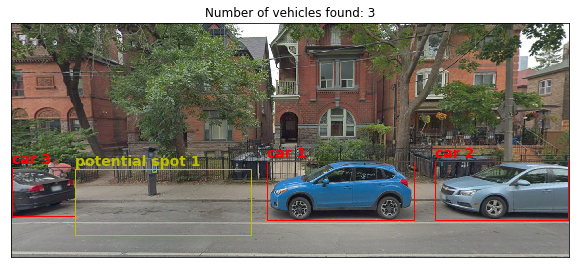

In [26]:
# let's apply the conditions to the images
car_detection(im_dir, resp_dir, conditions, save_image = True)

We can see that potential spots are detected in `onstreet_parking_a`,`onstreet_parking_b` and `onstreet_parking_c`. They are represented by yellow rectangles.

Now let's identify potential spots in additional images.

Image: onstreet_parking_1
car 1
confidence 0.92
Rectangle(xy=(1193.49, 585.92), width=865.601, height=344.127, angle=0)
car 2
confidence 0.89
Rectangle(xy=(132.09, 661.633), width=876.121, height=292.35, angle=0)
car 3
confidence 0.83
Rectangle(xy=(2031.3, 599.016), width=451.236, height=303.398, angle=0)


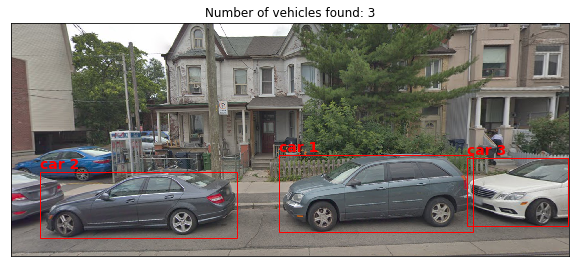

Image: onstreet_parking_2
car 1
confidence 0.91
Rectangle(xy=(0, 689.232), width=829.769, height=321.169, angle=0)
car 2
confidence 0.91
Rectangle(xy=(984.103, 647.468), width=736.464, height=330.939, angle=0)
car 3
confidence 0.88
Rectangle(xy=(1874.31, 627.44), width=613.231, height=319.216, angle=0)


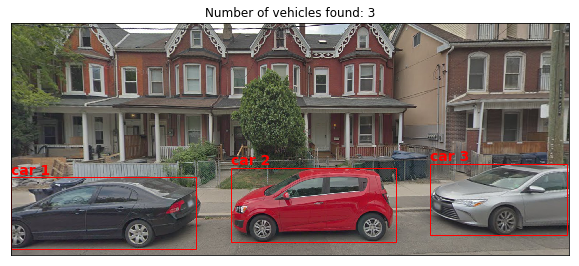

Image: onstreet_parking_5
Rectangle(xy=(0, 655.285), width=789, height=292.185, angle=0)
Rectangle(xy=(789, 655.285), width=789, height=292.185, angle=0)
Rectangle(xy=(1578, 655.285), width=789, height=292.185, angle=0)


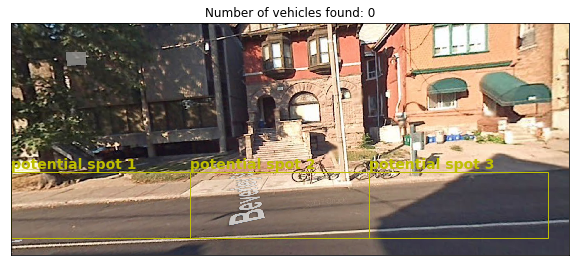

Image: onstreet_parking_4
car 1
confidence 0.91
Rectangle(xy=(811.64, 644.036), width=618.421, height=233.472, angle=0)
car 2
confidence 0.73
Rectangle(xy=(1.76189, 649.336), width=597.278, height=242.628, angle=0)


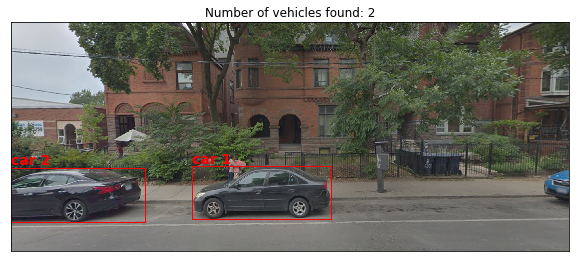

Image: onstreet_parking_3
car 1
confidence 0.89
Rectangle(xy=(538.79, 494.997), width=1127.7, height=451.617, angle=0)
car 2
confidence 0.83
Rectangle(xy=(9.85856, 443.063), width=379.474, height=442.365, angle=0)
car 3
confidence 0.73
Rectangle(xy=(1748.14, 433.656), width=755.669, height=532.466, angle=0)


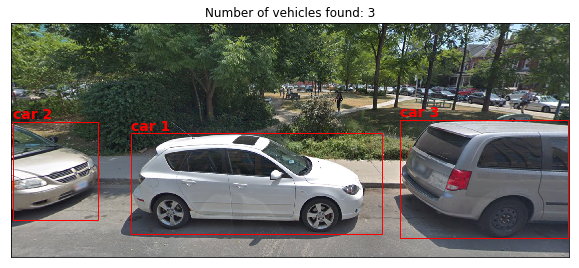

In [27]:
# additional image and response folders
extra_im_dir = 'onstreet_parking_images_extra/'
extra_resp_dir = 'onstreet_parking_json_responses_extra/'

car_detection(extra_im_dir, extra_resp_dir,conditions, save_image = True)

## Predicting Spot Availability

### Obtaining the Data

In our fully functional application we will be populating our "predicting spot availability" training model's input from the previous step "on-street parking" (time of day and day of week of the captured empty spot) and the output of the training model based on the time the user park in that spot.  

To evaluate our prediction analysis we will be using for this project the parking data that is available for the public use by the Melbourne city government, from ```data.melbourne.vic.gov.au```.


The parking data contains a list of all "parking events" for a given parking sensor. The sensors are installed on on-street parking spots around the city. These "parking events" track the start and end of the event, as well as other metadata including duration, location, nearby street, violation, etc.


It is assumed that every "event" represents a change in state of the parking sensor, from occupied to free to occupied and so on. It is also worth noting that the sensors only collect data from 7:30 AM to 6:30 PM. Parking overnight is not allowed, which allows for the assumption that the parking spots start unoccupied every day.

In [28]:
# sodapy is used to fetch data from the Melbourne government website
from sodapy import Socrata

# Fetch data from government website for a random street in Melbourne
client = Socrata("data.melbourne.vic.gov.au", None)
result_list = client.get("7jq6-k9kf", limit= 500000, streetid=178) 
results_df = pd.DataFrame.from_records(result_list)

# narrow down the deviceid (i.e. the parking spot) list to focus on a smaller segment to train the model
parking_spots = np.array(['6236', '6238', '6240', '6241', '6242', '6245', '6246', '6251',
       '6252', '6253', '6254', '6257', '6258', '6259', '6260'])
 
parking_events = results_df.loc[results_df['deviceid'].isin(parking_spots)]

Printing the first few rows of the parking events dataframe reveals the described "parking events" format along with all the available metadata.

In [29]:
parking_events.head()

area              arrivaltime   betweenstreet1    betweenstreet2  \
4   Jolimont  2013-05-23T12:17:10.000  GISBORNE STREET  LANSDOWNE STREET   
10  Jolimont  2013-01-31T14:16:47.000  GISBORNE STREET  LANSDOWNE STREET   
15  Jolimont  2013-08-21T16:38:59.000  GISBORNE STREET  LANSDOWNE STREET   
17  Jolimont  2013-08-18T10:39:21.000  GISBORNE STREET  LANSDOWNE STREET   
20  Jolimont  2013-03-15T16:23:55.000  GISBORNE STREET  LANSDOWNE STREET   

              departuretime deviceid durationseconds in_violation  \
4   2013-05-23T12:17:17.000     6260               7        False   
10  2013-01-31T17:12:33.000     6258           10546         True   
15  2013-08-21T16:39:19.000     6260              20        False   
17  2013-08-18T10:39:31.000     6242              10        False   
20  2013-03-15T16:24:02.000     6251               7        False   

   side_of_street                       sign streetid streetmarker  \
4               3  2P TKT A M-SAT 7:30-18:30      178       12420N   
10              3  2P TKT A M-SAT 7:30-18:30      178       12416N   
15              3  2P TKT A M-SAT 7:30-18:30      178       12420N   
17              4          1P SUN 7:30-18:00      178       12393S   
20              3  2P TKT A M-SAT 7:30-18:30      178       12402N   

         streetname  
4   CATHEDRAL PLACE  
10  CATHEDRAL PLACE  
15  CATHEDRAL PLACE  
17  CATHEDRAL PLACE  
20  CATHEDRAL PLACE

### Cleaning the Data

We begin by removing unnecessary columns from the dataframe, and filtering out events which are less than 60 seconds assumed to be misfirings of the sensors or a car in the process of parking (readjusting).

The arrival and departure times are then converted into ```timestamps``` to be more easily processed and sorted.

In [30]:
pd.options.mode.chained_assignment = None 

# drop all the extra columns on location, signage, etc.
parking_events.drop(['area','betweenstreet1','betweenstreet2','in_violation','side_of_street','sign','streetid','streetmarker','streetname'], axis=1, inplace=True)
parking_events.durationseconds = parking_events.durationseconds.astype(np.int64)

# filter out events that are less than 60s, assuming they are misfiring of sensor
parking_events = parking_events.loc[parking_events['durationseconds'] > 60]

# convert the arrival and departure times into a timestamp (ie # of seconds since "The Epoch"...Jan 1900)
def convert_time(time_string):
    timestamp = time.mktime(datetime.datetime.strptime(time_string, "%Y-%m-%dT%H:%M:%S.000").timetuple())
    return timestamp
    
parking_events['start_time'] = parking_events['arrivaltime'].apply(convert_time)
parking_events['end_time'] = parking_events['departuretime'].apply(convert_time)

# sort by deviceid (parking spot), and then by the start time for easy processing.
parking_events = parking_events.sort_values(['deviceid', 'start_time'], ascending=[True, True]);

Go through the sorted data and label the appropriate events as either empty or occupied spots (with ```is_empty```).

In [31]:
def check_day_start(time_string): # chek if the time of the event is at 7:30 AM so it can be classified in our dataframe
    date_time = datetime.datetime.strptime(time_string, "%Y-%m-%dT%H:%M:%S.000")
    Time=date_time.time()
    return Time.minute==30 and Time.hour==7 and Time.second ==0

parking_events['is_day_start'] = parking_events['arrivaltime'].apply(check_day_start)
parking_events['is_empty'] = True

parking_events=parking_events.reset_index()
parking_events.drop(['index'],axis=1,inplace=True)

is_spot_empty = True
for i in range(len(parking_events)):
    
    if parking_events.loc[i,'is_day_start']:
        is_spot_empty = True
        parking_events.loc[i,'is_empty'] = True
        
    else:
        is_spot_empty = not is_spot_empty
        parking_events.loc[i,'is_empty'] = is_spot_empty

### Preparing the Data

It is clear that most times the spot is empty, it remains empty for a very short period of time (over 25% of empty events are less than 500s or ~8min long). This suggests that spots that empty up are quickly taken, which seems reasonable for a downtown on-street parking location.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38604ff2e8>]],
      dtype=object)

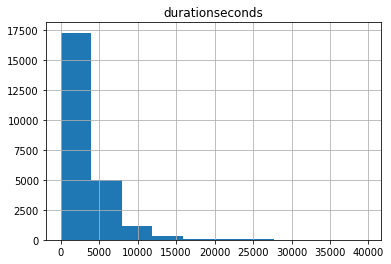

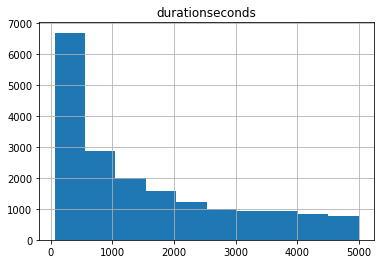

In [32]:
parking_events_empty = parking_events.loc[parking_events['is_empty']] # as it will be probably due to wrong reading or driver
parking_events_empty.hist(column='durationseconds') #                 # his parking space
parking_events_empty.loc[parking_events_empty.durationseconds <5000].hist(column='durationseconds')

To further prepare the data for modeling, we convert the timestamps into more manageable time of day buckets. We also extract the day of the week. This forms our two main features:

1. Day of Week: a number from 0 to 6, with 0 being Monday
2. Time of Day: a number from 1 to 5:
    - 1 is morning from 7:30 AM to 9:59 AM
    - 2 is brunch/midday from 10:00 AM to 11:59 PM
    - 3 is lunch from 12:00 PM to 1:59 PM
    - 4 is afternoon from 2:00 PM to 4:59 PM
    - 5 is evening from 5:00 PM to 6:30 PM
    
The duration is also placed in buckets to simplify prediction. Since we are more interested in providing the user an estimate for how long the parking spot might remain available, the following buckets are defined:
- 1: < 15 min before spot is taken
- 2: < 60 min before spot is taken
- 3: < 2 hours before spot is taken
- 4: < 3 hours before spot is taken
- 5: anything longer than 3 hours

In [33]:
def convert_day(time_string): # taking out the day of the week from the time stamp of the event 
    thedate = datetime.datetime.strptime(time_string, "%Y-%m-%dT%H:%M:%S.000")
    day_of_week=thedate.weekday() #Monday is 0, Sunday is 6
    return day_of_week

def convert_time(time_string): # taking out the time of day from the time stamp of the event
    date_time = datetime.datetime.strptime(time_string, "%Y-%m-%dT%H:%M:%S.000")
    Time=date_time.time()
    Time_Minutes=Time.hour*60+Time.minute+Time.second/60
    #Time_Minutes1=round(Time_Minutes/10,0)

    # adding a time classification to our data 
    if Time.hour <10:
        return '1'
    elif Time.hour <12:
        return '2'
    elif Time.hour <14:
        return '3'
    elif Time.hour <17:
        return '4'
    else:
        return '5'

parking_events_empty['day_of_week'] = parking_events_empty['arrivaltime'].apply(convert_day)
parking_events_empty['time_of_day'] = parking_events_empty['arrivaltime'].apply(convert_time)


def duration_buckets(duration): # creating a function that create buckets for the time of empty parking spots
    if duration < 15*60:
        return 1
    elif duration < 60*60:
        return 2
    elif duration < 120*60:
        return 3
    elif duration < 180*60:
        return 4
    else: 
        return 5

parking_events_empty['time_empty_bucket'] = parking_events_empty['durationseconds'].apply(duration_buckets)

In [34]:
parking_events_empty.head()

arrivaltime            departuretime deviceid  durationseconds  \
1  2013-01-01T07:54:12.000  2013-01-01T08:01:24.000     6236              432   
3  2013-01-01T08:12:35.000  2013-01-01T08:44:16.000     6236             1901   
5  2013-01-01T11:01:05.000  2013-01-01T11:53:23.000     6236             3138   
7  2013-01-01T13:41:56.000  2013-01-01T14:32:15.000     6236             3019   
9  2013-01-01T14:34:52.000  2013-01-01T17:34:27.000     6236            10775   

     start_time      end_time  is_day_start  is_empty  day_of_week  \
1  1.357027e+09  1.357027e+09         False      True            1   
3  1.357028e+09  1.357030e+09         False      True            1   
5  1.357038e+09  1.357041e+09         False      True            1   
7  1.357048e+09  1.357051e+09         False      True            1   
9  1.357051e+09  1.357062e+09         False      True            1   

  time_of_day  time_empty_bucket  
1           1                  1  
3           1                  2  
5           2                  2  
7           3                  2  
9           4                  4

### Modeling the Data

To model the data we used three predictors:
- Gaussian Naive Bayes
- Logistic Regression
- multinomial Naive Bayes

The parking events are considered independent and the estimation we are trying to model is based on conditional information of time and day. The important amount of parking data could be considered distributed as per a Gaussian distribution. 
As will be demonstrated below, the Gaussian NB had the highest results.

In [35]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
 
X=parking_events_empty[['time_of_day','day_of_week']]
Y=parking_events_empty['time_empty_bucket']

# splitting the data into 80 % train and 20 % test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0) 
model = GaussianNB()
model.fit(X_train, y_train) #fitting our model
target_pred = model.predict(X_test)

# model_results will have the predicted and tested results for comparison
model_results = pd.DataFrame({'Actual': y_test, 'Predicted': target_pred}) 

# showing several metrics to get an idea of the performance of the results
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, target_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, target_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, target_pred))) 
print('Accuracy:',metrics.accuracy_score(y_test,target_pred))
print(metrics.classification_report(y_test, target_pred))

Mean Absolute Error: 1.0331872260488415
Mean Squared Error: 2.1356710498852016
Root Mean Squared Error: 1.4613935301229446
Accuracy: 0.37925276560217075
              precision    recall  f1-score   support

           1       0.37      0.92      0.53      1754
           2       0.42      0.13      0.20      1527
           3       0.00      0.00      0.00      1030
           4       0.00      0.00      0.00       350
           5       0.00      0.00      0.00       130

   micro avg       0.38      0.38      0.38      4791
   macro avg       0.16      0.21      0.15      4791
weighted avg       0.27      0.38      0.26      4791



/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Now let's output the results of Logistic Regression with Cross validation.

In our parking model the logistic regression measures the probability of the input to be part of each class separately. This model was selected since we put our data and prediction in classes and logistic regression is a good class estimator.


In [36]:
from sklearn.linear_model import LogisticRegressionCV

model2 = LogisticRegressionCV(cv=10,solver='newton-cg', multi_class = 'ovr') # logistic regression model 
model2.fit(X_train, y_train)
target_pred = model2.predict(X_test)
 
model_results2 = pd.DataFrame({'Actual': y_test, 'Predicted': target_pred}) 


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, target_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, target_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, target_pred))) 
print('Accuracy:',metrics.accuracy_score(y_test,target_pred))
print(metrics.classification_report(y_test, target_pred))

Mean Absolute Error: 1.076393237319975
Mean Squared Error: 2.2702984763097476
Root Mean Squared Error: 1.506750966918471
Accuracy: 0.36610310999791273
              precision    recall  f1-score   support

           1       0.37      1.00      0.54      1754
           2       0.00      0.00      0.00      1527
           3       0.00      0.00      0.00      1030
           4       0.00      0.00      0.00       350
           5       0.00      0.00      0.00       130

   micro avg       0.37      0.37      0.37      4791
   macro avg       0.07      0.20      0.11      4791
weighted avg       0.13      0.37      0.20      4791



/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
# storing the results
model_results.to_csv('results.csv')

Finally let's try to fit the data with the Naive Bayes Multinomial model.
Naive Bayes is a good classifier for our model as it is based on independent results based on prior event knowledge. 

In [38]:
from sklearn.naive_bayes import MultinomialNB
X=parking_events_empty[['time_of_day', 'day_of_week']]
Y=parking_events_empty['time_empty_bucket']

clf = MultinomialNB().fit(X_train,y_train)
predicted = clf.predict(X_test)
score = metrics.accuracy_score(y_test,predicted)
score
print(metrics.classification_report(y_test, target_pred))

              precision    recall  f1-score   support

           1       0.37      1.00      0.54      1754
           2       0.00      0.00      0.00      1527
           3       0.00      0.00      0.00      1030
           4       0.00      0.00      0.00       350
           5       0.00      0.00      0.00       130

   micro avg       0.37      0.37      0.37      4791
   macro avg       0.07      0.20      0.11      4791
weighted avg       0.13      0.37      0.20      4791



/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Per the classification report, Naive Bayes Multinomial didn't perform as well as Gaussian NB.

Hence Gaussian Naive Bayes is the model selected.